In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv("train_V2.csv")
test = pd.read_csv("test_V2.csv")

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).

Data fields

DBNOs - Number of enemy players knocked.
assists - Number of enemy players this player damaged that were killed by teammates.
boosts - Number of boost items used.
damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
headshotKills - Number of enemy players killed with headshots.
heals - Number of healing items used.
Id - Player’s Id
killPlace - Ranking in match of number of enemy players killed.
killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
killStreaks - Max number of enemy players killed in a short amount of time.
kills - Number of enemy players killed.
longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
matchDuration - Duration of match in seconds.
matchId - ID to identify match. There are no matches that are in both the training and testing set.
matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
revives - Number of times this player revived teammates.
rideDistance - Total distance traveled in vehicles measured in meters.
roadKills - Number of kills while in a vehicle.
swimDistance - Total distance traveled by swimming measured in meters.
teamKills - Number of times this player killed a teammate.
vehicleDestroys - Number of vehicles destroyed.
walkDistance - Total distance traveled on foot measured in meters.
weaponsAcquired - Number of weapons picked up.
winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
numGroups - Number of groups we have data for in the match.
maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [3]:
print(train.shape,test.shape,sep='\n')

(4446966, 29)
(1934174, 28)


In [4]:
print(train.isnull().sum(),test.isnull().sum())

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64 Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0


There is only a single missing value, let's just remove that row.

In [5]:
train = train.dropna(axis=0)

train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [6]:
train.head(20)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000,1,1,0,44,...,0,0.0000,0,0.00,0,0,34.70,1,0,0.0370
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000,0,0,0,96,...,0,0.0000,0,0.00,0,0,13.50,1,1497,0.0000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,...,0,2004.0000,0,0.00,0,0,1089.00,6,1500,0.7368
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.600,0,0,0,64,...,0,0.0000,0,0.00,0,0,799.90,4,0,0.3704
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.270,0,0,0,74,...,0,0.0000,0,0.00,0,0,65.67,1,0,0.2143


In [7]:
#I don't think groupId and matchId are relevant so let's remove them

train.drop(['groupId','matchId'], axis=1, inplace=True)
test.drop(['groupId','matchId'], axis=1, inplace=True)

In [8]:
train.head()

,Id,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,0,0,0.00,0,0,0,60,1241,0,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,0,0,91.47,0,0,0,57,0,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,1,0,68.00,0,0,0,47,0,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,0,0,32.90,0,0,0,75,0,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,0,0,100.00,0,0,0,45,0,1,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [9]:
#Let's take a look at 'matchType'

train['matchType'].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

FPP stands for First Person Perspective

the classic modes are solo, solo-fpp, duo, duo-fpp, squad, squad-fpp

In [10]:
#Get ready for some Visualization

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# to draw graphs inside the notebook
%matplotlib inline

<AxesSubplot:xlabel='matchType', ylabel='winPlacePerc'>

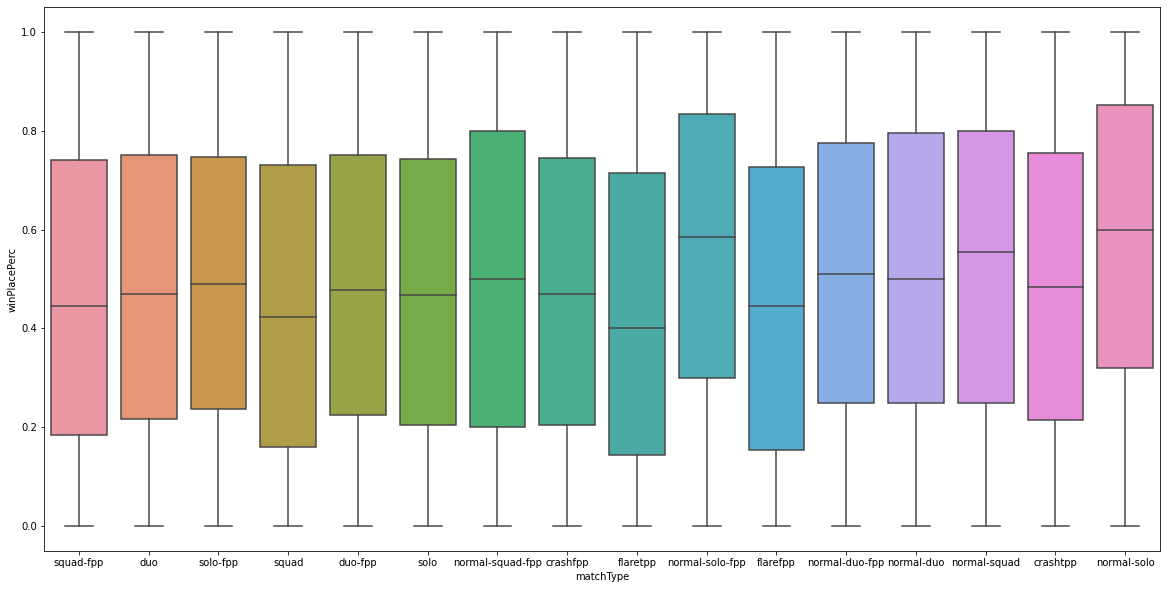

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.boxplot(data=train, x="matchType", y="winPlacePerc", orient='v')

In [12]:
#combining train and test dataset
train_test_data = [train, test] 

In [13]:
#Let's map this
#solo(and related): 0, duo: 1, squad: 2, other: 3

matchType_mapping = {'solo': 0, 'solo-fpp': 0, 'normal-solo': 0, 'normal-solo-fpp': 0, 'duo': 1, 
                     'duo-fpp': 1, 'normal-duo': 1, 'normal-duo-fpp': 1, 'squad': 2, 'squad-fpp': 2, 
                     'normal-squad-fpp': 2, 'normal-squad': 2, 'crashfpp': 3, 'flaretpp': 3,
                    'flarefpp': 3, 'crashtpp': 3}

for dataset in train_test_data:
    dataset['matchType'] = dataset['matchType'].map(matchType_mapping)

In [14]:
train['matchType'].unique()

array([2, 1, 0, 3])

<AxesSubplot:xlabel='matchType', ylabel='winPlacePerc'>

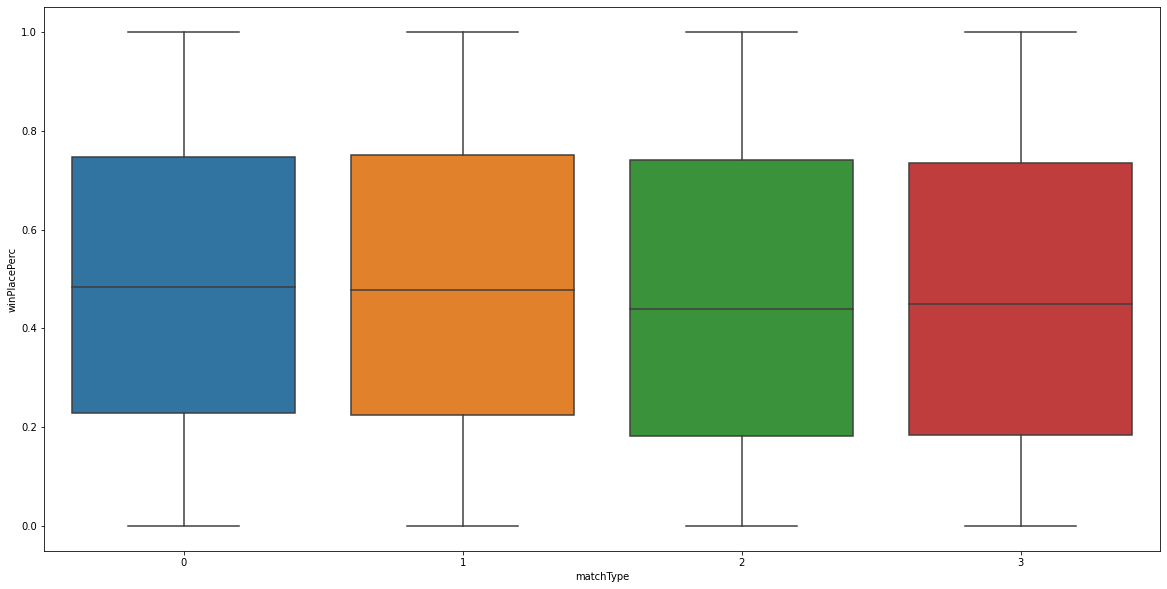

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.boxplot(data=train, x="matchType", y="winPlacePerc", orient='v')

Looks like winPlacePerc slightly increases if you play solo or duo

In [16]:
feature_list = list(train.columns)
print(feature_list)

['Id', 'assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc']


In [17]:
#Let's check the correlation

corrMatt = train[feature_list]
corrMatt = corrMatt.corr()
#print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

<AxesSubplot:>

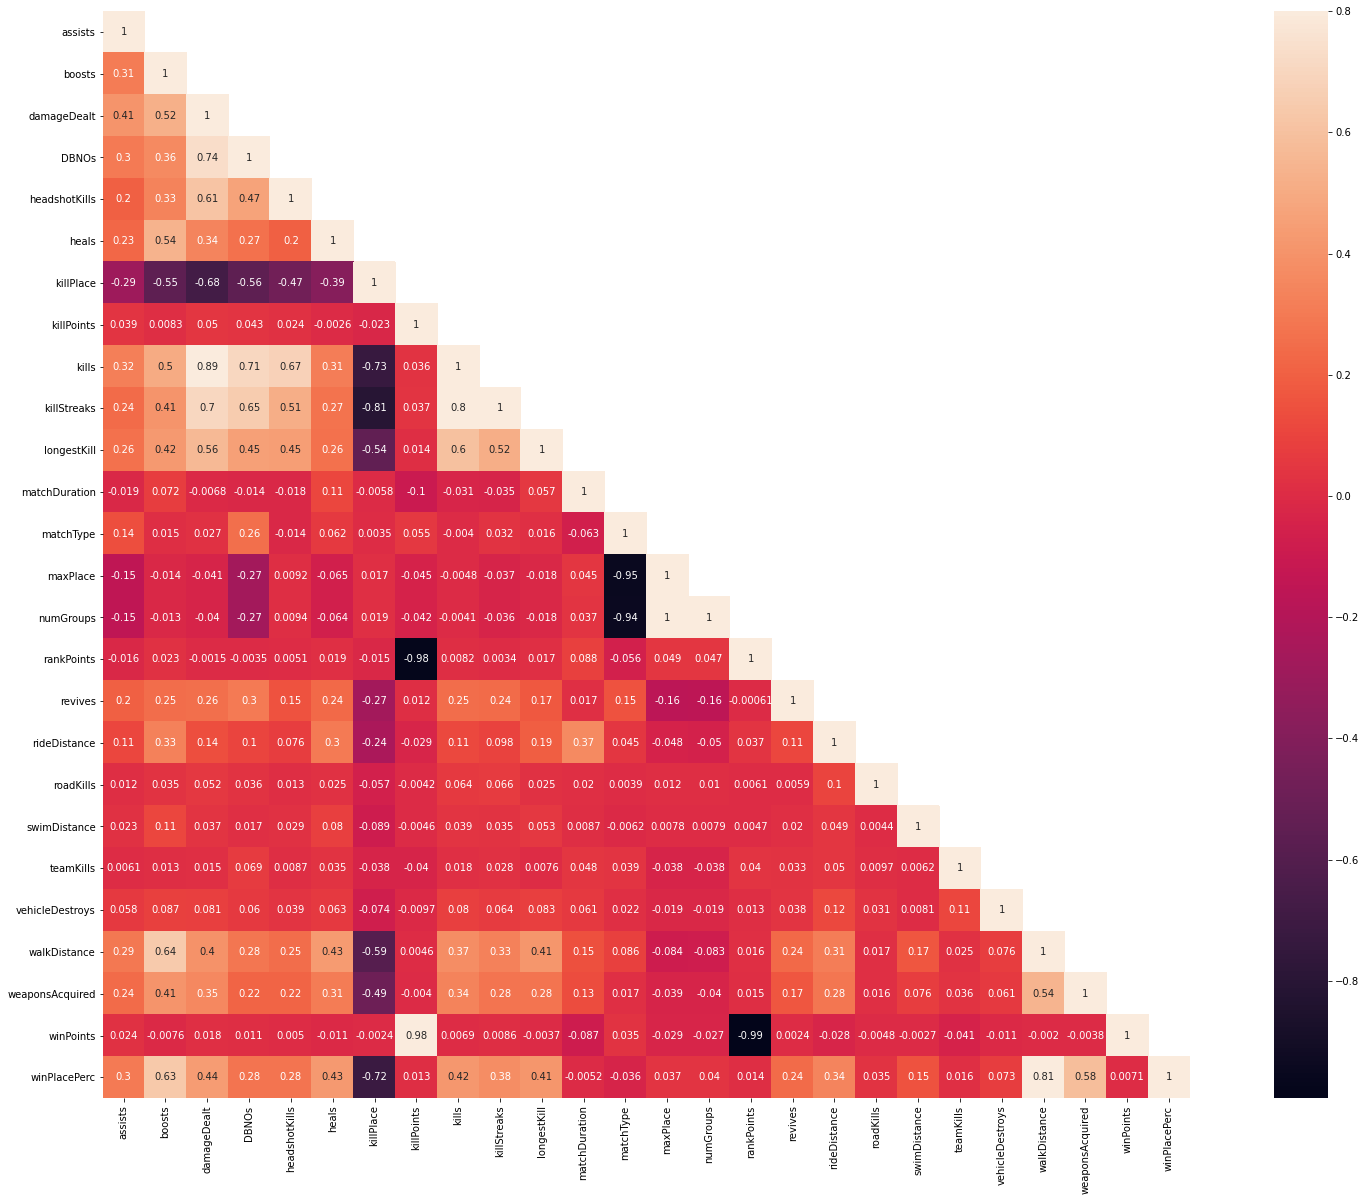

In [18]:
##HEAT MAP

fig, ax = plt.subplots()
fig.set_size_inches(30,20)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

This is purely based on my intuition

Variables with high correlation to winPlacePerc(>0.5):
boosts, killPlace(negative), walkDistance, weaponsAcquired

variables with moderate correlation to winPlacePerc(>0.3):
assists, damageDealt, heals, kills, killStreaks, longestKill, rideDistance

In [19]:
###PREPARATION
real_feature_list = ['boosts', 'killPlace', 'walkDistance', 'weaponsAcquired', 'assists', 
                    'damageDealt', 'heals', 'kills', 'killStreaks', 'longestKill', 'rideDistance']

X_train = train[real_feature_list]

print(X_train.shape)
X_train.head()

(4446965, 11)


,boosts,killPlace,walkDistance,weaponsAcquired,assists,damageDealt,heals,kills,killStreaks,longestKill,rideDistance
0,0,60,244.80,1,0,0.00,0,0,0,0.00,0.0000
1,0,57,1434.00,5,0,91.47,0,0,0,0.00,0.0045
2,0,47,161.80,2,1,68.00,0,0,0,0.00,0.0000
3,0,75,202.70,3,0,32.90,0,0,0,0.00,0.0000
4,0,45,49.75,2,0,100.00,0,1,1,58.53,0.0000


In [20]:
X_test = test[real_feature_list]

print(X_test.shape)
X_test.head()

(1934174, 11)


,boosts,killPlace,walkDistance,weaponsAcquired,assists,damageDealt,heals,kills,killStreaks,longestKill,rideDistance
0,0,73,588.0,1,0,51.46,0,0,0,0.00,0.0
1,4,11,2017.0,6,0,179.10,2,2,1,361.90,4669.0
2,0,49,787.8,4,1,23.40,4,0,0,0.00,0.0
3,0,54,1812.0,3,0,65.52,0,0,0,0.00,0.0
4,4,7,2963.0,4,0,330.20,1,3,1,60.06,0.0


In [21]:
label_name = "winPlacePerc"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(4446965,)


0    0.4444
1    0.6400
2    0.7755
3    0.1667
4    0.1875
Name: winPlacePerc, dtype: float64

In [22]:
print(X_test.shape,X_train.shape,y_train.shape)

(1934174, 11) (4446965, 11) (4446965,)


In [23]:
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [24]:
# Split the train and the validation set for the fitting

random_seed=1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, 
                                                  random_state=random_seed)

In [25]:
m3 = RandomForestRegressor(n_estimators=70, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)

In [26]:
%%time
m3.fit(X_train, y_train)

CPU times: user 33min 2s, sys: 16.9 s, total: 33min 19s
Wall time: 9min 12s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=70,
                      n_jobs=-1)

In [27]:
print('mae train: ', mean_absolute_error(m3.predict(X_train), y_train))
print('mae val: ', mean_absolute_error(m3.predict(X_val), y_val))

mae train:  0.049732809832779605
mae val:  0.07355560284061972


In [28]:
%%time
pred = m3.predict(X_test)
test['winPlacePerc'] = pred
submission = test[['Id', 'winPlacePerc']]
submission.to_csv('submission.csv', index=False)

import os
os.system('say "프로그램이 정상 종료되었습니다."')

CPU times: user 2min 43s, sys: 15 s, total: 2min 58s
Wall time: 1min 2s


0

(array([240622., 212935., 206826., 200230., 179093., 165755., 168621.,
        190970., 236642., 132480.]),
 array([2.41486634e-05, 9.96191744e-02, 1.99214200e-01, 2.98809226e-01,
        3.98404252e-01, 4.97999278e-01, 5.97594303e-01, 6.97189329e-01,
        7.96784355e-01, 8.96379381e-01, 9.95974406e-01]),
 <BarContainer object of 10 artists>)

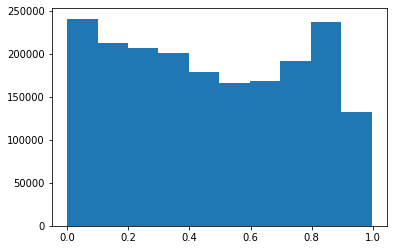

In [29]:
plt.hist(pred)

(array([559538., 436621., 415857., 368876., 347150., 380803., 338666.,
        347439., 384851., 422467.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

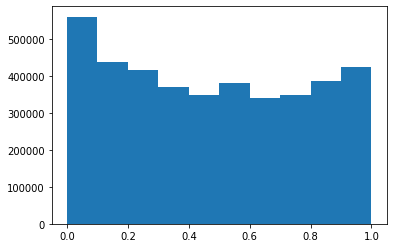

In [30]:
plt.hist(y_train)